In [1]:
from vegetation.preprocessing.ndvi_prep import remove_ndvi_outliers
import os 
import xarray as xr
from utils.function_clns import config
import logging
from vegetation.preprocessing.ndvi_prep import load_eumetsat_ndvi_max
from dask.diagnostics import ProgressBar
import pyproj
from vegetation.preprocessing.ndvi_prep import NDVIPreprocess
import numpy as np
import matplotlib.pyplot as plt

baseline_path = config["DEFAULT"]["local"] #config["NDVI"]["ndvi_path"]

os.environ['PROJ_LIB'] = pyproj.datadir.get_data_dir()

chunks={"time":-1, "lat":90, "lon":90}
filename = "seviri_full_image_smoothed.zarr"
ds_clean = xr.open_zarr(os.path.join(baseline_path, filename), 
                        chunks=chunks)
streaks_data = xr.open_zarr(os.path.join(
    baseline_path, 
    "mask_num_streaks.zarr"),
    chunks=chunks)

# Step 2: Calculate length of each streak
total_length = streaks_data.streaks.sum(dim='time')
num_streaks = streaks_data.streaks.count(dim='time')
days = len(streaks_data["time"])
max_strike = streaks_data.streaks.max(dim='time')

# Step 3: Calculate average
average_length = total_length / num_streaks
fraction_streaks = total_length/days

ds_clean["ndvi_clean"] = ds_clean["ndvi"].where(streaks_data.quality_flag<=45)
ds_clean["ndvi_clean"] = remove_ndvi_outliers(ds_clean["ndvi_clean"], impute=True)

filepath = os.path.join(baseline_path, "seviri_daily_ndvimax.nc")
max_ndvi = load_eumetsat_ndvi_max(filepath, 
                                  chunks=chunks)
modis_ds = xr.open_zarr(os.path.join(baseline_path, "ndvi_daily_modis.zarr"),
                        chunks= {"time":"auto", "lat":"auto", "lon":"auto"})

modis_ga = xr.open_zarr(os.path.join(baseline_path, "MOD09GA_ndvi.zarr"),
                        chunks= {"time":"auto", "lat":"auto", "lon":"auto"})

ds_ndvi = NDVIPreprocess(ds_clean["ndvi_clean"]).get_processed_data()
max_ndvi = NDVIPreprocess(max_ndvi).get_processed_data()
modis_ndvi = NDVIPreprocess(modis_ds["ndvi"]).get_processed_data()
modis_ga_ndvi = NDVIPreprocess(modis_ga["ndvi"]).get_processed_data()

### Load clouds data
def cloud_preprocess(ds):
    from utils.xarray_functions import add_time
    ds = add_time(ds)
    return ds

def load_cloud_ds(cloudfolder, parallel):
    from utils.function_clns import config
    cloud_path = os.path.join(config["NDVI"]["cloud_path"], cloudfolder)
    files = [os.path.join(cloud_path, file) for file in os.listdir(cloud_path) if file.endswith(".nc")]
    return xr.open_mfdataset(files, 
                            preprocess=cloud_preprocess, 
                            engine='netcdf4', 
                            parallel=parallel)

ds_cl = load_cloud_ds("09_15", False)
ds_cloud = NDVIPreprocess(ds_cl["cloud_mask"]).get_processed_data()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/abc.py:85: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 90. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/woden/an

In [65]:
from utils.xarray_functions import ndvi_colormap

cmap = ndvi_colormap()

with ProgressBar():
    ds_ndvi.mean(["time"]).to_dataset(name="NDVI")["NDVI"].plot(cmap=cmap, vmin = -0.2, vmax = 1)
    plt.title("Horn of Africa mean NDVI", fontsize=12)
    plt.grid(True, color="grey", alpha=0.2)
    plt.show()

[                                        ] | 0% Completed | 425.07 us

[########################################] | 100% Completed | 16.50 ss


In [3]:
from utils.function_clns import prepare, align_datasets
from utils.xarray_functions import odc_reproject
import pandas as pd
from rasterio.enums import Resampling
chunks = {"time":-1, "lat":80, "lon":80}

# geobox_eumetsat = geobox_from_rio(max_ndvi)

logging.info("Starting reprojecting...")
ds_repr_eu = odc_reproject(ds_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_eu["lat"] = max_ndvi["lat"]
ds_repr_eu["lon"] = max_ndvi["lon"]

logging.info("Succesfully reprojected our dataset")

ds_repr_mod = odc_reproject(modis_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod["lat"] = max_ndvi["lat"]
ds_repr_mod["lon"] = max_ndvi["lon"]

cloud_repr = odc_reproject(ds_cloud, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

cloud_repr["lat"] = max_ndvi["lat"]
cloud_repr["lon"] = max_ndvi["lon"]


ds_repr_mod_ga = odc_reproject(modis_ga_ndvi, max_ndvi, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod_ga["lat"] = max_ndvi["lat"]
ds_repr_mod_ga["lon"] = max_ndvi["lon"]

ds1, ds2, ds3, ds4 = align_datasets( ds_repr_eu,
                                    max_ndvi,
                                    ds_repr_mod,
                                    cloud_repr)

# ds1, ds2 = align_datasets(ds_repr_eu, max_ndvi, chunks=chunks)
# ds3, ds4 = align_datasets(ds_repr_mod, max_ndvi, chunks=chunks)
# ds5, ds6 = align_datasets(ds_repr_mod, ds_repr_eu, chunks=chunks)
# ds7, ds8 = align_datasets(ds_repr_mod_ga, max_ndvi, chunks=chunks)

INFO:root:Starting reprojecting...
INFO:root:Succesfully reprojected our dataset


In [129]:
def create_copernicus_covermap(dataset:xr.DataArray):
    import geemap    
    import ee
    from utils.function_clns import config, prepare
    import geopandas as gpd
    from utils.xarray_functions import geobox_from_rio

    def generate_new_data():
        print("Generating new landcover dataset")

        ee.Authenticate()
        ee.Initialize()
        geemap.ee_initialize()

        geometry_hoa = ee.Geometry.Rectangle(30.288233396779802,  -5.949173816626356 , 
                                             51.9972177717798, 15.808293611760663)

        landcover = ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019")\
            .select("discrete_classification")\
            .reproject(crs='EPSG:4326', crsTransform=list(geobox.transform)[:6])\
            .clip(geometry_hoa)

        gdf = gpd.read_file(shapefile_path)
        fc_poly = geemap.geopandas_to_ee(gdf)
        poly_geometry = fc_poly.geometry()


        geemap.ee_export_image(landcover, 
                filename = filename,
                region = poly_geometry)

        return prepare(xr.open_dataset(filename, engine="rasterio"))

    geobox = geobox_from_rio(dataset)
    shapefile_path = config['SHAPE']['HOA']
    path_img = config["DEFAULT"]["images"]
    filename = os.path.join(path_img, "temp_cover.tif")

    if os.path.isfile(filename):
        print("File already exists")
        ds = prepare(xr.open_dataset(filename, engine="rasterio"))

        if ds.rio.resolution()[0] == dataset.rio.resolution()[0]:
            print("Loading extisting landcover dataset")
            return ds
        else:
            ds = generate_new_data()
            return ds
    else:
        ds = generate_new_data()
        return ds

In [152]:
from ancillary.esa_landuse import get_level_1
from utils.function_clns import subsetting_pipeline

cover_ds = create_copernicus_covermap(ds1)
cover_ds = subsetting_pipeline(cover_ds)
cover_ds["lat"] = ds1["lat"]
cover_ds["lon"] = ds1["lon"]
cover_ds = get_level_1(cover_ds, name="band_data").isel(band=0)

fraction_repr = prepare(fraction_streaks).rio.reproject_match(prepare(cover_ds))
green_mask = xr.where(
        cover_ds["band_data"].isin([11,12]), #   & (prepare(fraction_repr)>=0.5))
        1, 0 ).transpose("lat","lon")

forest = cover_ds["band_data"].where(
        cover_ds["band_data"].isin([11,12])).transpose("lat","lon")

water_bodies = xr.where(
        cover_ds["band_data"].isin([80]),
        1, 0 ).transpose("lat","lon")

File already exists
Loading extisting landcover dataset


In [4]:
with ProgressBar():
    ds1 = ds1.load()
    ds2 = ds2.load()
    ds3 = ds3.load()
    ds4 = ds4.load()

Loading extisting landcover dataset
[#######                                 ] | 18% Completed | 32.27 ss

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


[########################################] | 100% Completed | 13m 35s
[########################################] | 100% Completed | 27.38 ss
[########################################] | 100% Completed | 36m 45s
[########################################] | 100% Completed | 72.94 s


In [150]:
forest = forest.where(forest != 11, other=0).where(forest != 12, other=1)

In [158]:
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

shapefile_path = config["SHAPE"]["HOA"]
gdf = gpd.read_file(shapefile_path)

# Create a custom colormap
colors = ['darkgreen', 'lightgreen']  # Colors corresponding to categories 11 and 12
cmap = mcolors.ListedColormap(colors)
bounds = [11, 12]  # Category values
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8,6))
ax = plt.gca() 

plot = forest.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
plt.title("Horn of Africa forest area", fontsize=12)

# Customize the legend
legend_labels = {11: 'Closed forest', 12: 'Open forest'}

# Create proxy artists for legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels.values())]
plt.legend(handles=patches, title='Legend',loc='lower right', bbox_to_anchor=(1, 0))

# Add the shapefile
gdf.plot(ax=ax, color='none', edgecolor='black')

plt.grid(True, color="grey", alpha=0.2)
plt.show()

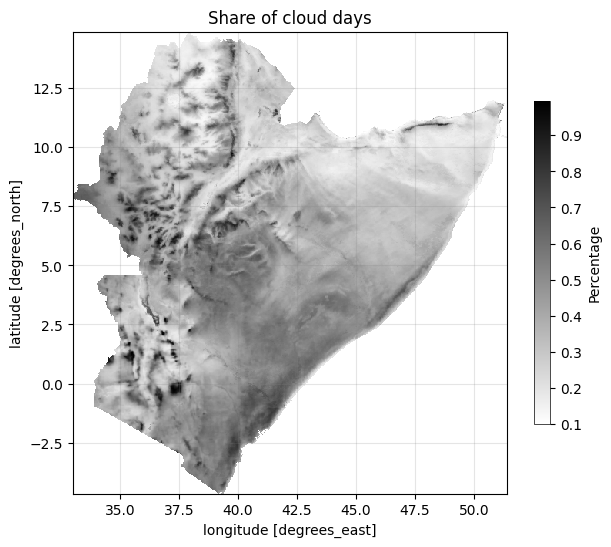

In [161]:
plt.figure(figsize=(7,6))
plot = subsetting_pipeline(fraction_streaks).plot(cmap="gist_yarg",add_colorbar=False)
plt.title("Share of cloud days", fontsize=12)
plt.grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
colorbar = plt.colorbar(plot, shrink=0.7)
colorbar.set_label('Percentage')
colorbar.set_alpha(1)  # Set transparency
colorbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
colorbar.outline.set_edgecolor('black')  # Set colorbar outline color
plt.show()

In [5]:
import xskillscore as xs

def print_metrics(corr, rmse, string1, string2):
    print(f"mean correlation between {string1} and {string2} is", corr.mean().values)
    print(f"mean rmse between {string1} and {string2} is", rmse.mean().values)
    # print(f"mean mae between {string1} and {string2} is", mae.mean().values)
    # print(f"mean mape between {string1} and {string2} is", mape.mean().values)

## Ours with EUMETSAT
with ProgressBar():
    corr_a = xs.pearson_r(ds1.where(water_bodies==0).where(ds4!=2), 
                          ds2.where(water_bodies==0).where(ds4!=2), 
                          dim="time", 
                          skipna=True)
    
    rmse_a = xs.rmse(ds1.where(water_bodies==0).where(ds4!=2), 
                     ds2.where(water_bodies==0).where(ds4!=2), 
                     dim="time", 
                     skipna=True)
    
    # mae_a = xs.mae(ds1, ds2, dim="time", skipna=True)
    # mape_a = xs.mape(ds1, ds2, dim="time", skipna=True)
    print_metrics(corr_a, rmse_a,"OURS", "EUMETSAT")
    
    corr_b = xs.pearson_r(ds1.where(water_bodies==0).where(ds4!=2), 
                          ds3.where(water_bodies==0).where(ds4!=2), 
                          dim="time", 
                          skipna=True)
    
    rmse_b = xs.rmse(ds1.where(water_bodies==0).where(ds4!=2), 
                     ds3.where(water_bodies==0).where(ds4!=2), 
                     dim="time", 
                     skipna=True)
    
    # mae_a = xs.mae(ds1, ds2, dim="time", skipna=True)
    # mape_a = xs.mape(ds1, ds2, dim="time", skipna=True)
    print_metrics(corr_b, rmse_b,"OURS", "MODIS")

    ### EUMETSAT with MODIS
    corr_c = xs.pearson_r(ds2.where(water_bodies==0).where(ds4!=2), 
                          ds3.where(water_bodies==0).where(ds4!=2), 
                          dim="time", 
                          skipna=True).load()
    rmse_c = xs.rmse(ds2.where(water_bodies==0).where(ds4!=2), 
                     ds3.where(water_bodies==0).where(ds4!=2), 
                     dim="time", 
                     skipna=True).load()
    # mae_c = xs.mae(ds5, ds6, dim="time", skipna=True)
    # mape_c = xs.mape(ds5, ds6, dim="time", skipna=True)
    print_metrics(corr_c, rmse_c,"EUMETSAT", "MODIS")

mean correlation between OURS and EUMETSAT is 0.824589
mean rmse between OURS and EUMETSAT is 0.046250653
mean correlation between OURS and MODIS is 0.5006786
mean rmse between OURS and MODIS is 0.110350706
mean correlation between EUMETSAT and MODIS is 0.5589642
mean rmse between EUMETSAT and MODIS is 0.110025845


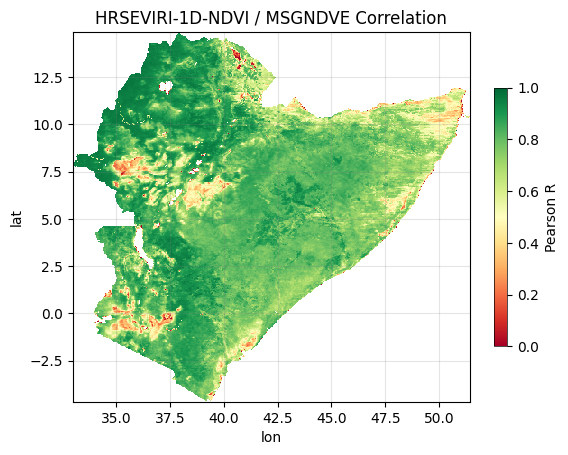

In [228]:
plot =  corr_a.plot(vmin=0, cmap="RdYlGn", add_colorbar=False)
plt.title("HRSEVIRI-1D-NDVI / MSGNDVE Correlation", fontsize=12)
plt.grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
colorbar = plt.colorbar(plot, shrink=0.7)
colorbar.set_label('Pearson R')
colorbar.set_alpha(1)  # Set transparency
colorbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
colorbar.outline.set_edgecolor('black')  # Set colorbar outline color
plt.show()

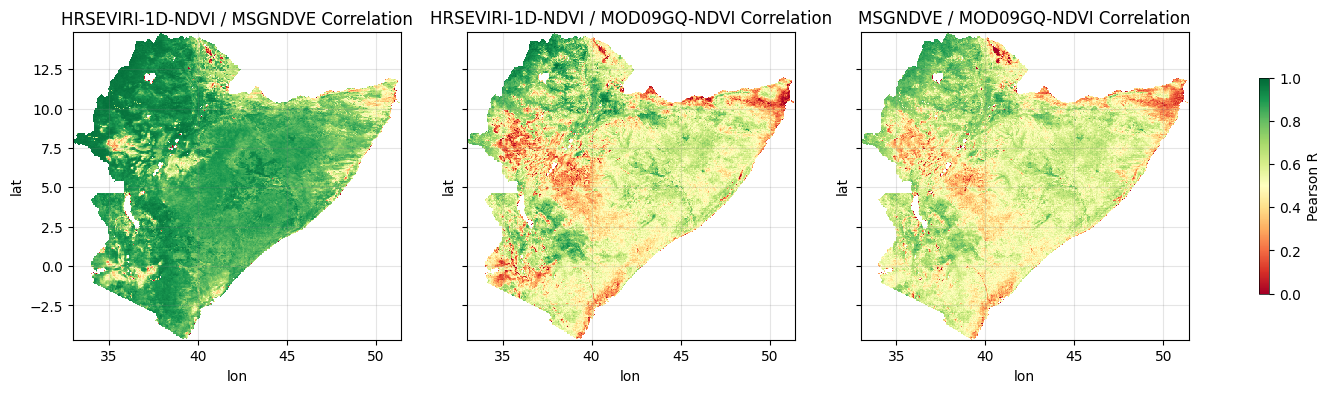

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-1D-NDVI / MSGNDVE Correlation", "HRSEVIRI-1D-NDVI / MOD09GQ-NDVI Correlation", "MSGNDVE / MOD09GQ-NDVI Correlation"]


for i, corr_data in enumerate([corr_a, corr_b, corr_c]):
    plot = corr_data.plot(ax=axs[i], vmin=0, cmap="RdYlGn", add_colorbar=False)
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)

# Adding colorbar with a title
cbar = fig.colorbar(plot, ax=axs.ravel().tolist(), shrink=0.7)
cbar.set_label('Pearson R')
cbar.set_alpha(1)  # Set transparency
cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

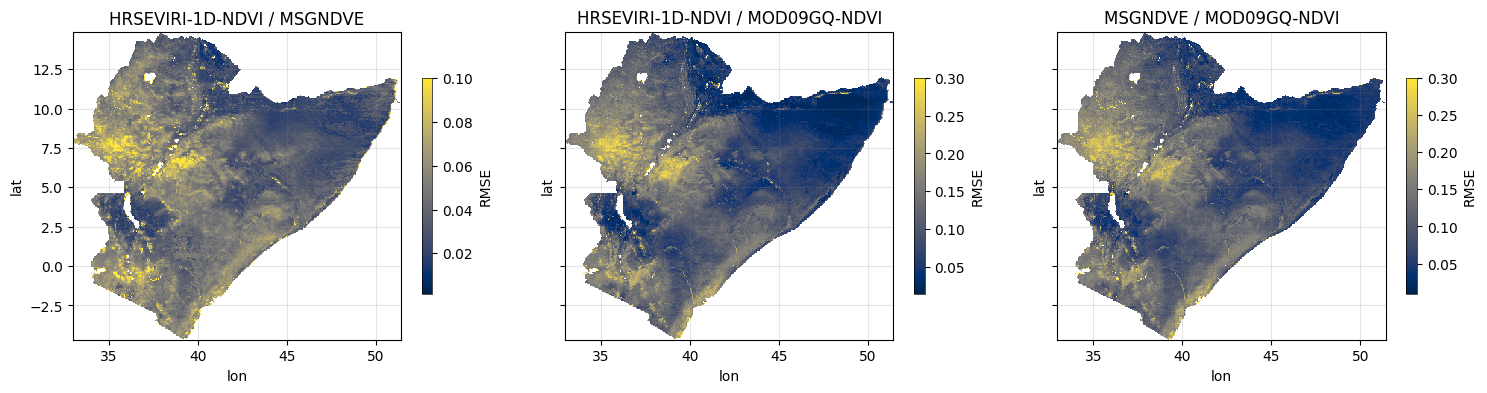

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-1D-NDVI / MSGNDVE", "HRSEVIRI-1D-NDVI / MOD09GQ-NDVI", "MSGNDVE / MOD09GQ-NDVI"]
vmax = [0.1, 0.3, 0.3]


for i, corr_data in enumerate([rmse_a, rmse_b, rmse_c]):
    plot = corr_data.plot(ax=axs[i], vmax = vmax[i], cmap="cividis", add_colorbar=False)
    axs[i].set_title(titles[i], fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)


    # Adding colorbar with a title
    cbar = fig.colorbar(plot, ax=axs[i], shrink=0.7)
    cbar.set_label('RMSE')
    cbar.set_alpha(1)  # Set transparency
    cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
    cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()

In [20]:
# Extract predicted and real values
import numpy as np

predicted_values = ds1.where(water_bodies==0).where(ds4!=2).values.flatten()
real_values1 = ds2.where(water_bodies==0).where(ds4!=2).values.flatten()
real_values2 = ds3.where(water_bodies==0).where(ds4!=2).values.flatten()


# arr1 = predicted_values[~np.isnan(predicted_values)]
# arr2 = real_values[~np.isnan(real_values)]

In [21]:
datasets = [predicted_values, real_values1, real_values2]
pairs = [(1, 0), (2, 0), (2, 1)]
titles = ['HRSEVIRI-1D-NDVI', 'MSGNDVE','MOD09GQ-NDVI' ] 
colors = ["Blues", "Greens", "Oranges"]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Creating subplots

for i, (idx1, idx2) in enumerate(pairs):
    axs[i].hexbin(datasets[idx1], datasets[idx2], gridsize=50, vmin=100, bins='log', cmap=colors[i])
    axs[i].set_title(f"{titles[idx1]} and {titles[idx2]}")
    axs[i].set_xlabel(f'{titles[idx1]}')
    axs[i].set_xlim(0, 0.9)
    axs[i].set_ylim(-0.2, 0.9)
    axs[i].set_ylabel(f'{titles[idx2]}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

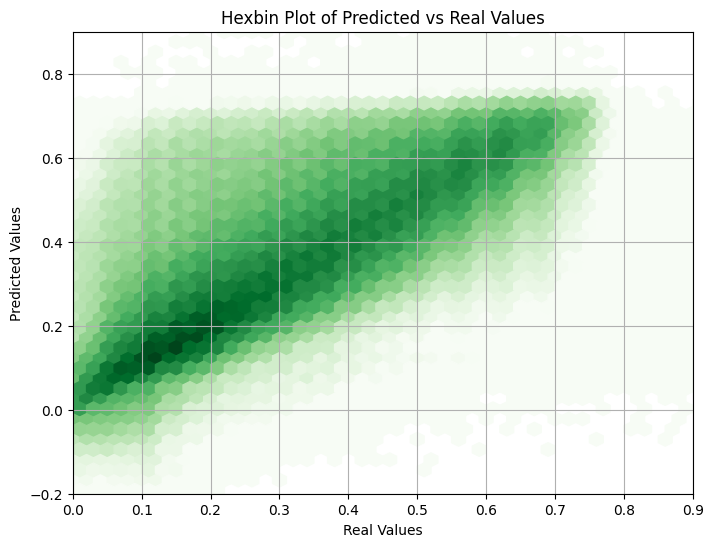

In [252]:
import matplotlib.pyplot as plt
# Create a hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(real_values, predicted_values, gridsize=50, vmin = 100, bins='log', cmap='Greens')
plt.title('Hexbin Plot of Predicted vs Real Values')
plt.xlabel('Real Values')
plt.xlim(0, 0.9)
plt.ylim(-0.2, 0.9)
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Autocorrelation

In [10]:
from vegetation.analysis.indices import autocorr
import matplotlib.pyplot as plt

lags = 30

lead_cunk = {"lat":"auto", "lon":"auto", "lead":"auto"}
auto_ds1 = autocorr(ds1.chunk(chunks), nlags=lags, skipna=True)
auto_ds2 = autocorr(ds2.chunk(chunks), nlags=lags, skipna=True)
auto_ds3 = autocorr(ds3.chunk(chunks), nlags=lags, skipna=True)
auto_ds4 = autocorr(ds4.chunk(chunks), nlags=lags, skipna=True)

with ProgressBar():
    auto_mean_3 = auto_ds3.mean(["lat","lon"])
    auto_mean_1 = auto_ds1.mean(["lat","lon"])
    auto_mean_2 = auto_ds2.mean(["lat","lon"])
    auto_mean_4 = auto_ds4.mean(["lat","lon"])
    auto_mean_3 = auto_mean_3.load()
    auto_mean_2 = auto_mean_2.load()
    auto_mean_1 = auto_mean_1.load()
    auto_mean_4 = auto_mean_4.load()

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/30 [00:00<?, ?it/s]

[###########                             ] | 28% Completed | 12m 26ss

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


[########################################] | 100% Completed | 39m 56s
[########################################] | 100% Completed | 26.97 ss
[########################################] | 100% Completed | 38m 21s
[########################################] | 100% Completed | 12m 51s
[########################################] | 100% Completed | 38m 58s
[########################################] | 100% Completed | 138.49 s
[########################################] | 100% Completed | 38m 59s
[########################################] | 100% Completed | 13m 36s


In [117]:
from vegetation.analysis.indices import autocorr
lags = 7
auto_ds6 = autocorr(ds6.chunk(chunks), nlags=lags, skipna=True)
auto_mean_6 = auto_ds6.mean(["lat","lon"])
df6 = auto_mean_6.to_dataframe()["ndvi_10"]


auto_ds7 = autocorr(ds7.chunk(chunks), nlags=lags, skipna=True)
auto_mean_7 = auto_ds7.mean(["lat","lon"])
df7 = auto_mean_7.to_dataframe(name="ndvi_10")["ndvi_10"]

auto_ds5 = autocorr(ds5.chunk(chunks), nlags=lags, skipna=True)
auto_mean_5 = auto_ds5.mean(["lat","lon"])
df5 = auto_mean_5.to_dataframe(name="ndvi_10")["ndvi_10"]


Processing lags...:   0%|          | 0/7 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/7 [00:00<?, ?it/s]

Processing lags...:   0%|          | 0/7 [00:00<?, ?it/s]

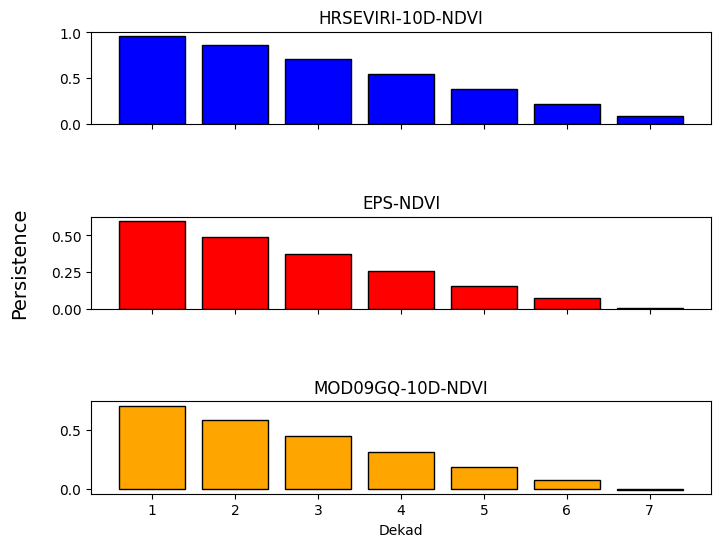

In [118]:
import matplotlib.pyplot as plt

# Assuming df1, df2, and df3 are your DataFrames
fig, axes = plt.subplots(3, 1, 
                         figsize=(8, 6), 
                         sharex=True)  # Create subplots with shared x-axis

# Plot each DataFrame in a separate subplot
axes[0].bar(df5.index + 1, df5, edgecolor='black', color="blue")
axes[1].bar(df6.index + 1, df6, edgecolor='black', color="red")
# axes[2].bar(df3.index + 1, df3, edgecolor='black', color="orange")
axes[2].bar(df7.index + 1, df7, edgecolor='black', color="orange")


axes[0].set_title("HRSEVIRI-10D-NDVI")
axes[1].set_title("EPS-NDVI")
axes[2].set_title("MOD09GQ-10D-NDVI")
# axes[3].set_title("MOD09GA-NDVI")

# Set labels and title

plt.xlabel('Dekad')
axes[1].set_ylabel('Persistence', fontsize=14)
axes[1].yaxis.set_label_coords(-0.1, 0.5)

# for ax in [axes[0], axes[1]]:
#     ax.set_ylim(, 1)

# Adjust space between subplots
plt.subplots_adjust(hspace=1)

# Adjust space between main title and subplot titles
# fig.suptitle('Autocorrelation', y=0.95, fontsize=16)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

df3 = auto_mean_3.to_dataframe(name="ndvi")["ndvi"]
df2 = auto_mean_2.to_dataframe(name="ndvi")["ndvi"]
df1 = auto_mean_1.to_dataframe(name="ndvi")["ndvi"]
df4 = auto_mean_4.to_dataframe(name="ndvi")["ndvi"]

# Assuming df1, df2, and df3 are your DataFrames
fig, axes = plt.subplots(3, 1, 
                         figsize=(8, 6), 
                         sharex=True)  # Create subplots with shared x-axis

# Plot each DataFrame in a separate subplot
axes[0].bar(df4.index + 1, df4, edgecolor='black', color="blue")
axes[1].bar(df2.index + 1, df2, edgecolor='black', color="red")
# axes[2].bar(df3.index + 1, df3, edgecolor='black', color="orange")
axes[2].bar(df1.index + 1, df1, edgecolor='black', color="orange")


axes[0].set_title("HRSEVIRI-1D-NDVI")
axes[1].set_title("MSGNDVE")
axes[2].set_title("MOD09GQ-NDVI")
# axes[3].set_title("MOD09GA-NDVI")

# Set labels and title

plt.xlabel('Days')
axes[1].set_ylabel('Persistence', fontsize=14)
axes[1].yaxis.set_label_coords(-0.1, 0.5)

for ax in [axes[0], axes[1]]:
    ax.set_ylim(0, 1)

# Adjust space between subplots
plt.subplots_adjust(hspace=1)

# Adjust space between main title and subplot titles
# fig.suptitle('Autocorrelation', y=0.95, fontsize=16)

plt.show()

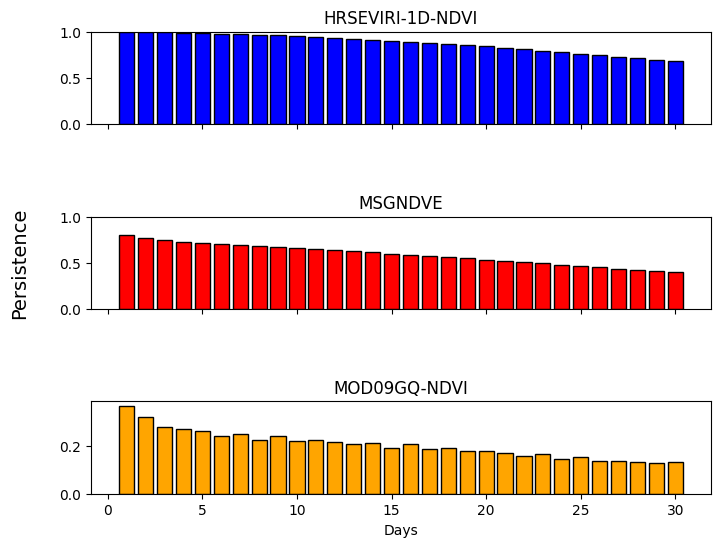

In [56]:
import matplotlib.pyplot as plt

df3 = auto_mean_3.to_dataframe(name="ndvi")["ndvi"]
df2 = auto_mean_2.to_dataframe(name="ndvi")["ndvi"]
df1 = auto_mean_1.to_dataframe(name="ndvi")["ndvi"]
df4 = auto_mean_4.to_dataframe(name="ndvi")["ndvi"]

# Assuming df1, df2, and df3 are your DataFrames
fig, axes = plt.subplots(3, 1, 
                         figsize=(8, 6), 
                         sharex=True)  # Create subplots with shared x-axis

# Plot each DataFrame in a separate subplot
axes[0].bar(df4.index + 1, df4, edgecolor='black', color="blue")
axes[1].bar(df2.index + 1, df2, edgecolor='black', color="red")
# axes[2].bar(df3.index + 1, df3, edgecolor='black', color="orange")
axes[2].bar(df1.index + 1, df1, edgecolor='black', color="orange")


axes[0].set_title("HRSEVIRI-1D-NDVI")
axes[1].set_title("MSGNDVE")
axes[2].set_title("MOD09GQ-NDVI")
# axes[3].set_title("MOD09GA-NDVI")

# Set labels and title

plt.xlabel('Days')
axes[1].set_ylabel('Persistence', fontsize=14)
axes[1].yaxis.set_label_coords(-0.1, 0.5)

for ax in [axes[0], axes[1]]:
    ax.set_ylim(0, 1)

# Adjust space between subplots
plt.subplots_adjust(hspace=1)

# Adjust space between main title and subplot titles
# fig.suptitle('Autocorrelation', y=0.95, fontsize=16)

plt.show()

In [ ]:
from typing import Union
import numpy as np

def select_random_points(mask: Union[xr.DataArray, xr.Dataset, None] = None,
                         n_points: int = 1):
    # Step 1: Apply boolean mask
    valid_indices = np.where(mask == 1)

    # Step 2: Generate random indices
    random_indices = np.random.choice(len(valid_indices[0]), 
                                      size=n_points, replace=False)
    
    return valid_indices, random_indices

def plot_random_masked_over_time(data_array1: Union[xr.DataArray, xr.Dataset],
                                 valid_indices:tuple, 
                                 random_indices:np.ndarray,
                                 date_min:str = None,
                                 date_max:str = None):
    
    if date_max and date_max is not None:
        data_array1 = data_array1.sel(time=slice(date_min, date_max))

    n_points = len(random_indices)

    # Step 3: Retrieve latitudes and longitudes corresponding to selected indices
    selected_lats = data_array1.lat.values[valid_indices[0][random_indices]]
    selected_lons = data_array1.lon.values[valid_indices[1][random_indices]]

    # Step 4: Generate time axis
    time_axis = data_array1.time.values

    # Step 5: Plot latitude-longitude combinations over time
    plt.figure(figsize=(10, 6))
    for i in range(n_points):
        plt.plot(time_axis, data_array1.sel(lat=selected_lats[i], lon=selected_lons[i]),
                 label=f'Lat: {selected_lats[i]}, Lon: {selected_lons[i]}', 
                 color=plt.cm.viridis(i / n_points), linestyle='-', marker='o', markersize=4, alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Data Variable')
    plt.title('Latitude-Longitude Combinations Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## NDVI 10 days

In [68]:
from typing import Union
def dataset_to_dekad(dataset:Union[xr.Dataset, xr.DataArray]):
    
    def group_into_dekads(date_list:list):
        result = []

        # Sort the list of dates to ensure correct grouping
        sorted_dates = [pd.to_datetime(t) for t in sorted(date_list)]

        threshold_days = [1, 11, 21]

        # Group dates into dekads
        current_dekad = []
        for idx in range(len(sorted_dates) - 1):  # Iterate up to the second-to-last element
            date = sorted_dates[idx]
            current_dekad.append(date)
            next_day = sorted_dates[idx+1].day
            if next_day in threshold_days:
                result.append(current_dekad)
                current_dekad = []

        # Handle the last element separately
        last_date = sorted_dates[-1]
        current_dekad.append(last_date)
        result.append(current_dekad)

        return result

    time_values = dataset["time"].values
    list_dates = group_into_dekads(time_values)

    final_dataset = None

    for date in list_dates:
        # Perform the operation on the subset of the dataset for the current date
        temp_ds = dataset.sel(time=date).max(["time"])
        temp_ds["time"] = date[0]

        # Append the resulting dataset to the final dataset
        if final_dataset is None:
            final_dataset = temp_ds
        else:
            final_dataset = xr.concat([final_dataset, temp_ds], dim="time")

    # Optionally, you can sort the final dataset by time
    final_dataset = final_dataset.sortby("time")

    return final_dataset

In [66]:
import xarray as xr 
import os
from vegetation.preprocessing.ndvi_prep import load_landsaf_ndvi
from utils.xarray_functions import dataset_to_dekad

path = "/media/BIFROST/N2/Riccardo/output"
target_store = "output_file.zarr"
zarr_path = os.path.join(path, target_store)
ds_lsaf = load_landsaf_ndvi(zarr_path)

ds_ndvi10 = dataset_to_dekad(ds_ndvi)
ds_mod10 = dataset_to_dekad(modis_ndvi)

logging.info("Starting reprojecting...")
ds_repr_eu10 = odc_reproject(ds_ndvi10, ds_lsaf, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_eu10["lat"] = ds_lsaf["lat"]
ds_repr_eu10["lon"] = ds_lsaf["lon"]

logging.info("Succesfully reprojected our dataset")

ds_repr_mod10 = odc_reproject(ds_mod10, ds_lsaf, resampling="bilinear")\
    .rename({"longitude": "lon", "latitude": "lat"})

ds_repr_mod10["lat"] = ds_lsaf["lat"]
ds_repr_mod10["lon"] = ds_lsaf["lon"]

ds5, ds6, ds7, _ = align_datasets(ds_repr_eu10, ds_lsaf, ds_repr_mod10)

In [84]:
with ProgressBar():
    ds5 = ds5.load()
    ds6 = ds6.load()
    ds7 = ds7.load()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f29a4e38dc0>>
Traceback (most recent call last):
  File "/home/woden/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[########################################] | 100% Completed | 96.44 s
[########################################] | 100% Completed | 7.13 sms
[########################################] | 100% Completed | 30m 19s


In [162]:
from ancillary.esa_landuse import get_level_1
from utils.function_clns import subsetting_pipeline, prepare

cover_ds = create_copernicus_covermap(prepare(ds6))
cover_ds = subsetting_pipeline(cover_ds)
cover_ds["lat"] = ds6["lat"]
cover_ds["lon"] = ds6["lon"]
cover_ds = get_level_1(cover_ds, name="band_data").isel(band=0)

fraction_repr = prepare(fraction_streaks).rio.reproject_match(prepare(cover_ds))
green_mask = xr.where(
        cover_ds["band_data"].isin([11,12]), #   & (prepare(fraction_repr)>=0.5))
        1, 0 ).transpose("lat","lon")

water_bodies = xr.where(
        cover_ds["band_data"].isin([80]),
        1, 0 ).transpose("lat","lon")

File already exists
Generating new landcover dataset
Generating URL ...
Please wait ...
Data downloaded to /media/BIFROST/N2/Riccardo/Indices_analysis/data/images/temp_cover.tif


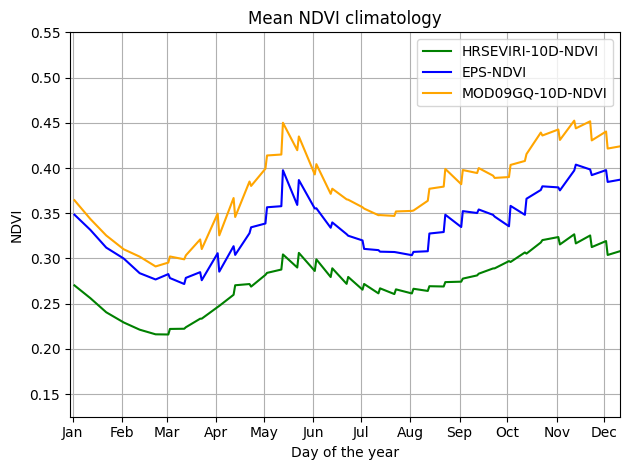

In [164]:
import matplotlib.dates as mdates

ds5.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green", label="HRSEVIRI-10D-NDVI")
ds6.ndvi_10.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue", label= "EPS-NDVI")
ds7.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="orange", label="MOD09GQ-10D-NDVI")

# Formatting x-axis ticks to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Get current x-axis limits
x_min, x_max = plt.xlim()

# Extend the x-axis limits to skip the last label
plt.xlim(x_min+15, x_max - 30)  # Skip the last 30 days
plt.ylim(0.125, 0.55)

plt.title('Mean NDVI climatology')
plt.legend()
plt.ylabel("NDVI")
plt.xlabel("Day of the year")
plt.grid(True)
plt.tight_layout()
plt.show()

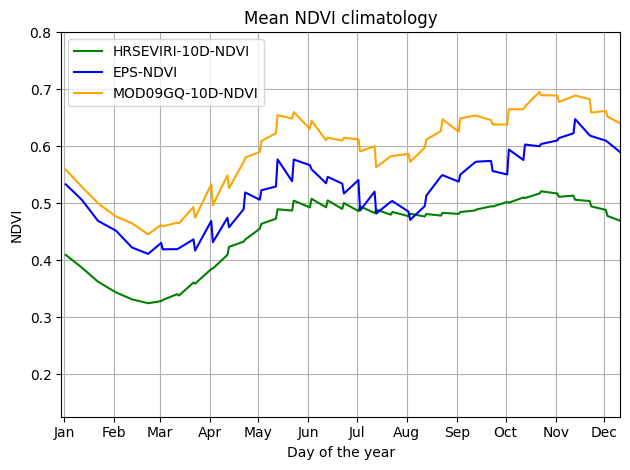

In [168]:
import matplotlib.dates as mdates

ds5.where(water_bodies==0).where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green", label="HRSEVIRI-10D-NDVI")
ds6.ndvi_10.where(water_bodies==0).where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue", label= "EPS-NDVI")
ds7.where(water_bodies==0).where(green_mask==1).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="orange", label="MOD09GQ-10D-NDVI")

# Formatting x-axis ticks to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Get current x-axis limits
x_min, x_max = plt.xlim()

# Extend the x-axis limits to skip the last label
plt.xlim(x_min+15, x_max - 30)  # Skip the last 30 days
plt.ylim(0.125, 0.8)

plt.title('Mean NDVI climatology')
plt.legend()
plt.ylabel("NDVI")
plt.xlabel("Day of the year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [98]:
## Ours with EUMETSAT
with ProgressBar():
    corr_d = xs.pearson_r(ds5.where(water_bodies==0), 
                          ds6.ndvi_10.where(water_bodies==0), 
                          dim="time", 
                          skipna=True)
    
    rmse_d = xs.rmse(ds5.where(water_bodies==0), 
                     ds6.ndvi_10.where(water_bodies==0), 
                     dim="time", 
                     skipna=True)
    
    # mae_a = xs.mae(ds1, ds2, dim="time", skipna=True)
    # mape_a = xs.mape(ds1, ds2, dim="time", skipna=True)
    print_metrics(corr_d, rmse_d,"OURS", "LSAF")
    
    corr_e = xs.pearson_r(ds5.where(water_bodies==0), 
                          ds7.where(water_bodies==0), 
                          dim="time", 
                          skipna=True)
    
    rmse_e = xs.rmse(ds5.where(water_bodies==0), 
                     ds7.where(water_bodies==0), 
                     dim="time", 
                     skipna=True)
    
    # mae_a = xs.mae(ds1, ds2, dim="time", skipna=True)
    # mape_a = xs.mape(ds1, ds2, dim="time", skipna=True)
    print_metrics(corr_e, rmse_e,"OURS", "MODIS")

    ### EUMETSAT with MODIS
    corr_f = xs.pearson_r(ds6.ndvi_10.where(water_bodies==0), 
                          ds7.where(water_bodies==0), 
                          dim="time", 
                          skipna=True).load()
    rmse_f = xs.rmse(ds6.ndvi_10.where(water_bodies==0), 
                     ds7.where(water_bodies==0), 
                     dim="time", 
                     skipna=True).load()
    # mae_c = xs.mae(ds5, ds6, dim="time", skipna=True)
    # mape_c = xs.mape(ds5, ds6, dim="time", skipna=True)
    print_metrics(corr_f, rmse_f,"LSAF", "MODIS")

mean correlation between OURS and LSAF is 0.6399269
mean rmse between OURS and LSAF is 0.103653476
mean correlation between OURS and MODIS is 0.7559908
mean rmse between OURS and MODIS is 0.12504815
mean correlation between LSAF and MODIS is 0.67730445
mean rmse between LSAF and MODIS is 0.09775321


## Plotting points

In [ ]:
start_date = "2017-01-01"
end_date = "2019-01-01"
n= 5

valid_indices, random_indices = select_random_points(green_mask, 
                                                     n_points = n)
# random_indices = [ 8289, 10619, 12757, 13611, 13922]

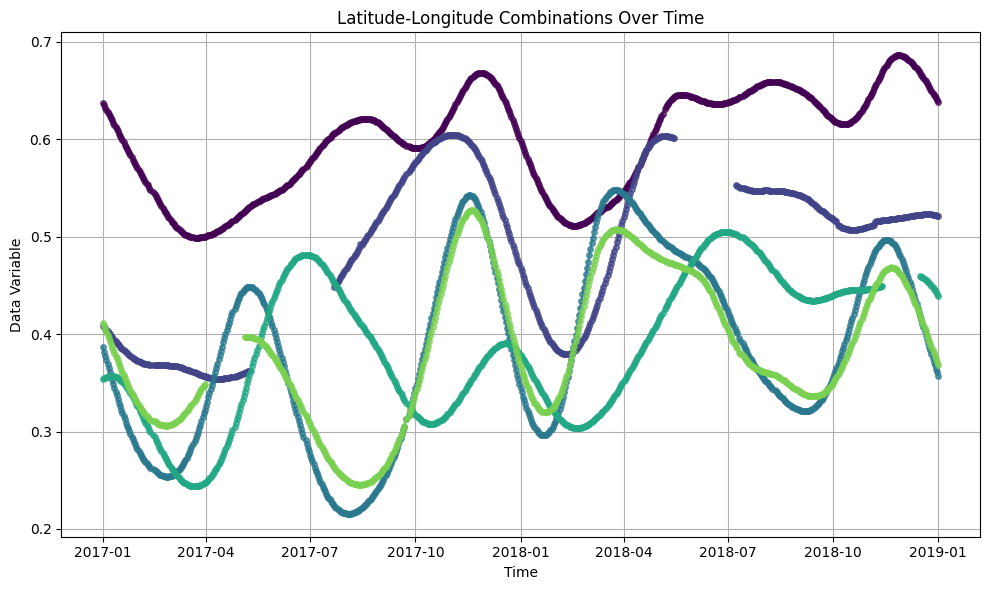

In [ ]:
# from analysis.visualizations.viz_series import plot_random_masked_over_time
import matplotlib.pyplot as plt
plot_random_masked_over_time(ds1, valid_indices, 
                             random_indices, start_date, end_date)

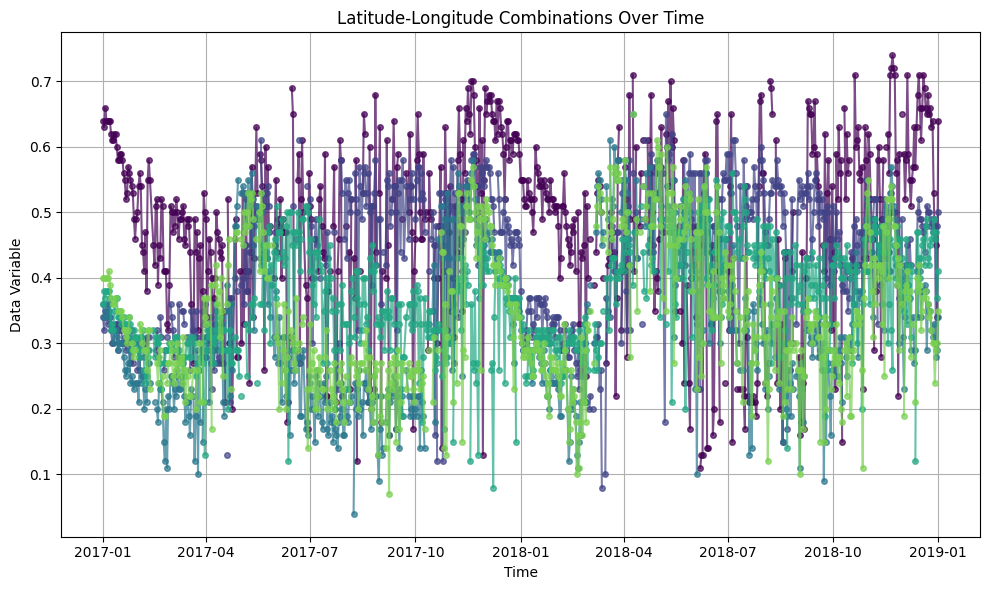

In [ ]:
plot_random_masked_over_time(ds2, valid_indices, random_indices, start_date, end_date)

In [ ]:
plot_random_masked_over_time(ds3, valid_indices, random_indices, start_date, end_date)

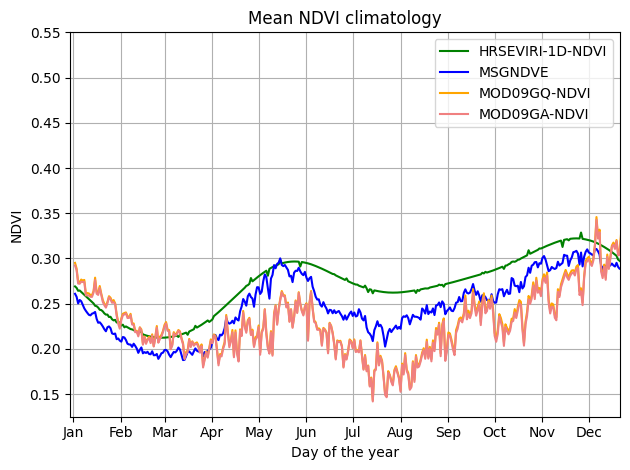

In [272]:
import matplotlib.dates as mdates

ds1.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="green", label="HRSEVIRI-1D-NDVI")
ds2.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="blue", label= "MSGNDVE")
ds3.where(water_bodies==0).groupby("time.dayofyear").mean().mean(["lat","lon"]).plot(color="orange", label="MOD09GQ-NDVI")

# Formatting x-axis ticks to show month names
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Abbreviated month names
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Get current x-axis limits
x_min, x_max = plt.xlim()

# Extend the x-axis limits to skip the last label
plt.xlim(x_min+15, x_max - 30)  # Skip the last 30 days
plt.ylim(0.125, 0.55)

plt.title('Mean NDVI climatology')
plt.legend()
plt.ylabel("NDVI")
plt.xlabel("Day of the year")
plt.grid(True)
plt.tight_layout()
plt.show()

###  Wildfires experiment

1) Simen mountains Semien National Park was started on March 26, 2019

In [ ]:
events = [{"lat":10.32, "lon":39.8, "time_min": "2021-11-20", "time_max": "2021-12-20"}]

In [13]:
shap_path = os.path.join(config["SHAPE"]["base"], "shape-files/Kenya/KEN_adm4.shp")
from utils.function_clns import cut_file
import geopandas as gpd

gdf = gpd.read_file(shap_path)
column = "NAME_3"
gdf[gdf[column].str.contains("Kenya")]

column = "NAME_2"
location = "Mt. Kenya"
list_locations = ["Meru", "Nyeri","Embu", "Nithi","Kirinyaga"]
subset = gdf[gdf[column].isin(list_locations)]
mt_kenya = cut_file(ds_clean.ndvi, subset)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gdf.to_crs(gdf.crs).plot(ax=ax,legend=True, cmap="tab20c")
subset.plot(ax=ax, color="blue", alpha=0.5)

In [26]:
from vegetation.analysis.indices import compute_vci

vci = compute_vci(ds_ndvi)

with ProgressBar():
    vci = vci.load()

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


[########################################] | 100% Completed | 337.47 s


In [39]:
time_min = "2006-02-01"
time_max = "2006-03-20"

/media/BIFROST/N2/Riccardo/Indices_analysis/src/analysis/visualizations/viz_series.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


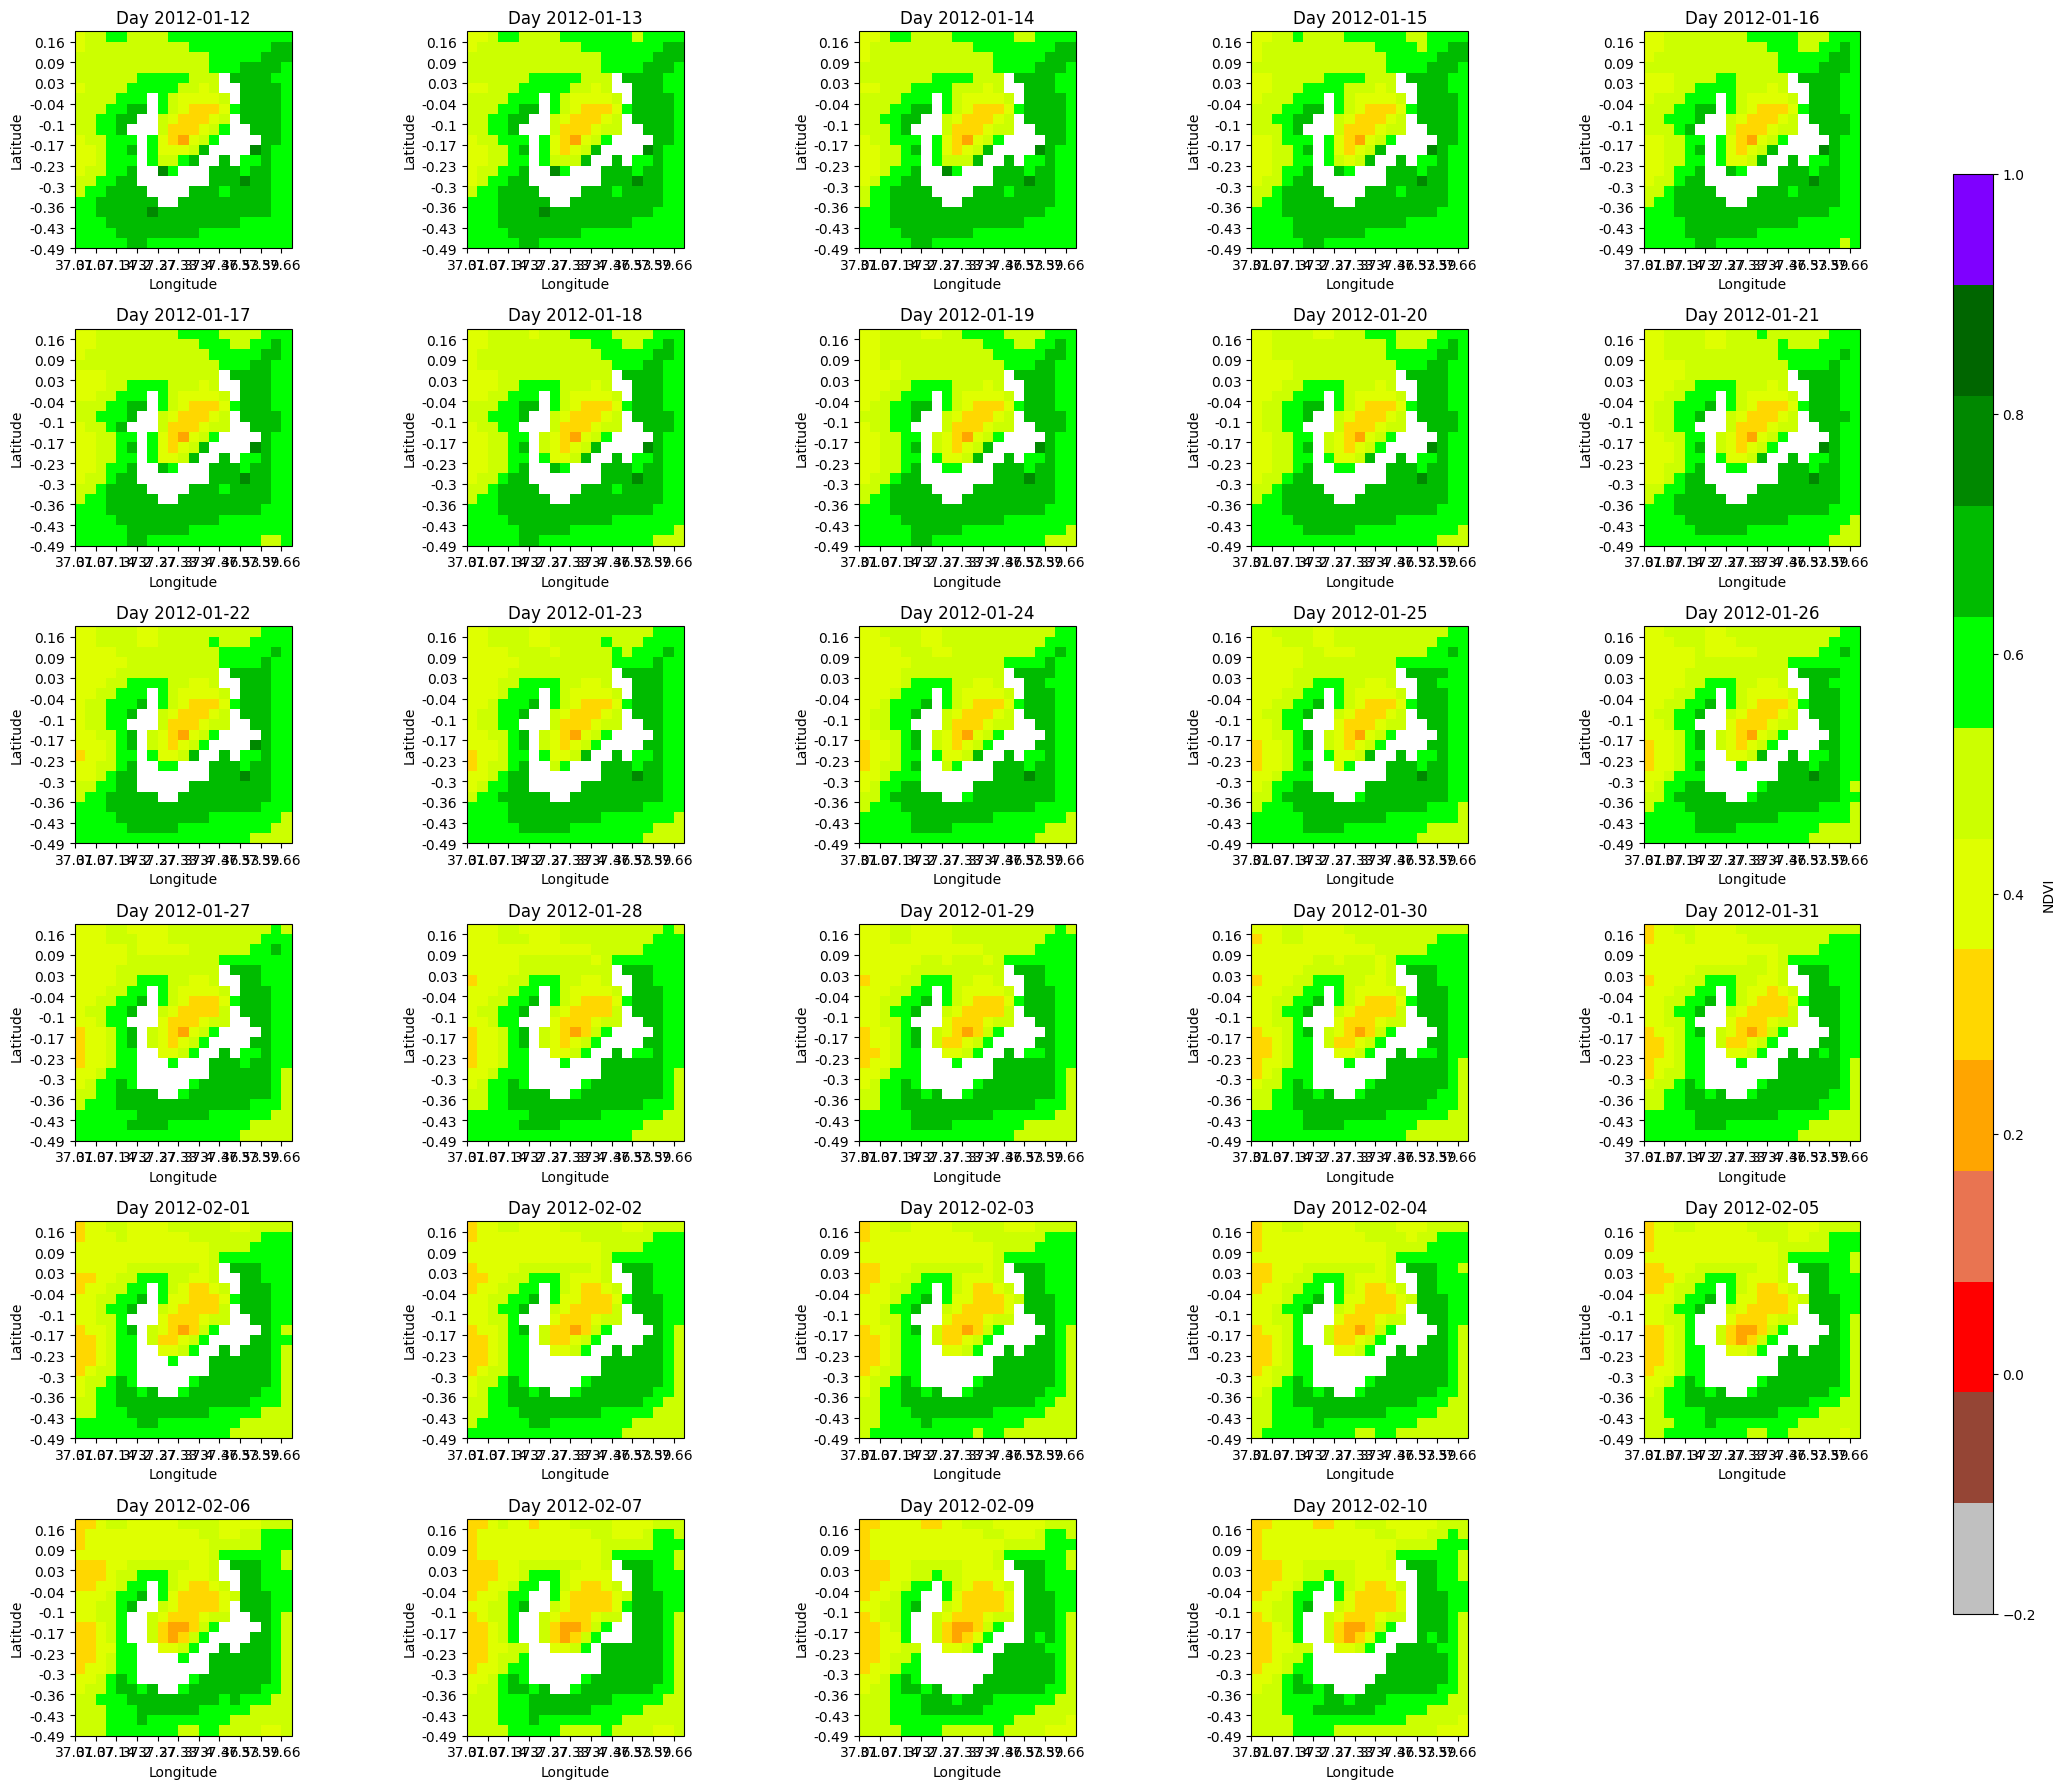

In [48]:
from analysis.visualizations.viz_series import plot_ndvi_days
import matplotlib.pyplot as plt

sub_area = ds_ndvi.sel(lat=slice(-0.5, 0.17 )).sel(lon=slice(37, 37.68))

time_min = "2012-01-12"
time_max = "2012-02-12"

cities = {
    "Timau": (0.05006, 37.14213),
    # "Nanyuki": (0.01667, 37.07283),
    #  "Chuka": (-0.33316, 37.64587),
    # "Kerugoya": (-0.49302, 37.26559),
    # "Meru": (0.053543, 37.648399),
    
}

# extra_area = 1.25

sub_ds = sub_area.sel(time=slice(time_min, time_max))
    #.sel(lat=slice(lat-extra_area, lat+extra_area))\
    # .sel(lon=slice(lon-extra_area, lon+extra_area)))

plot_ndvi_days(sub_ds, time_min, 30)

/media/BIFROST/N2/Riccardo/Indices_analysis/src/analysis/visualizations/viz_series.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


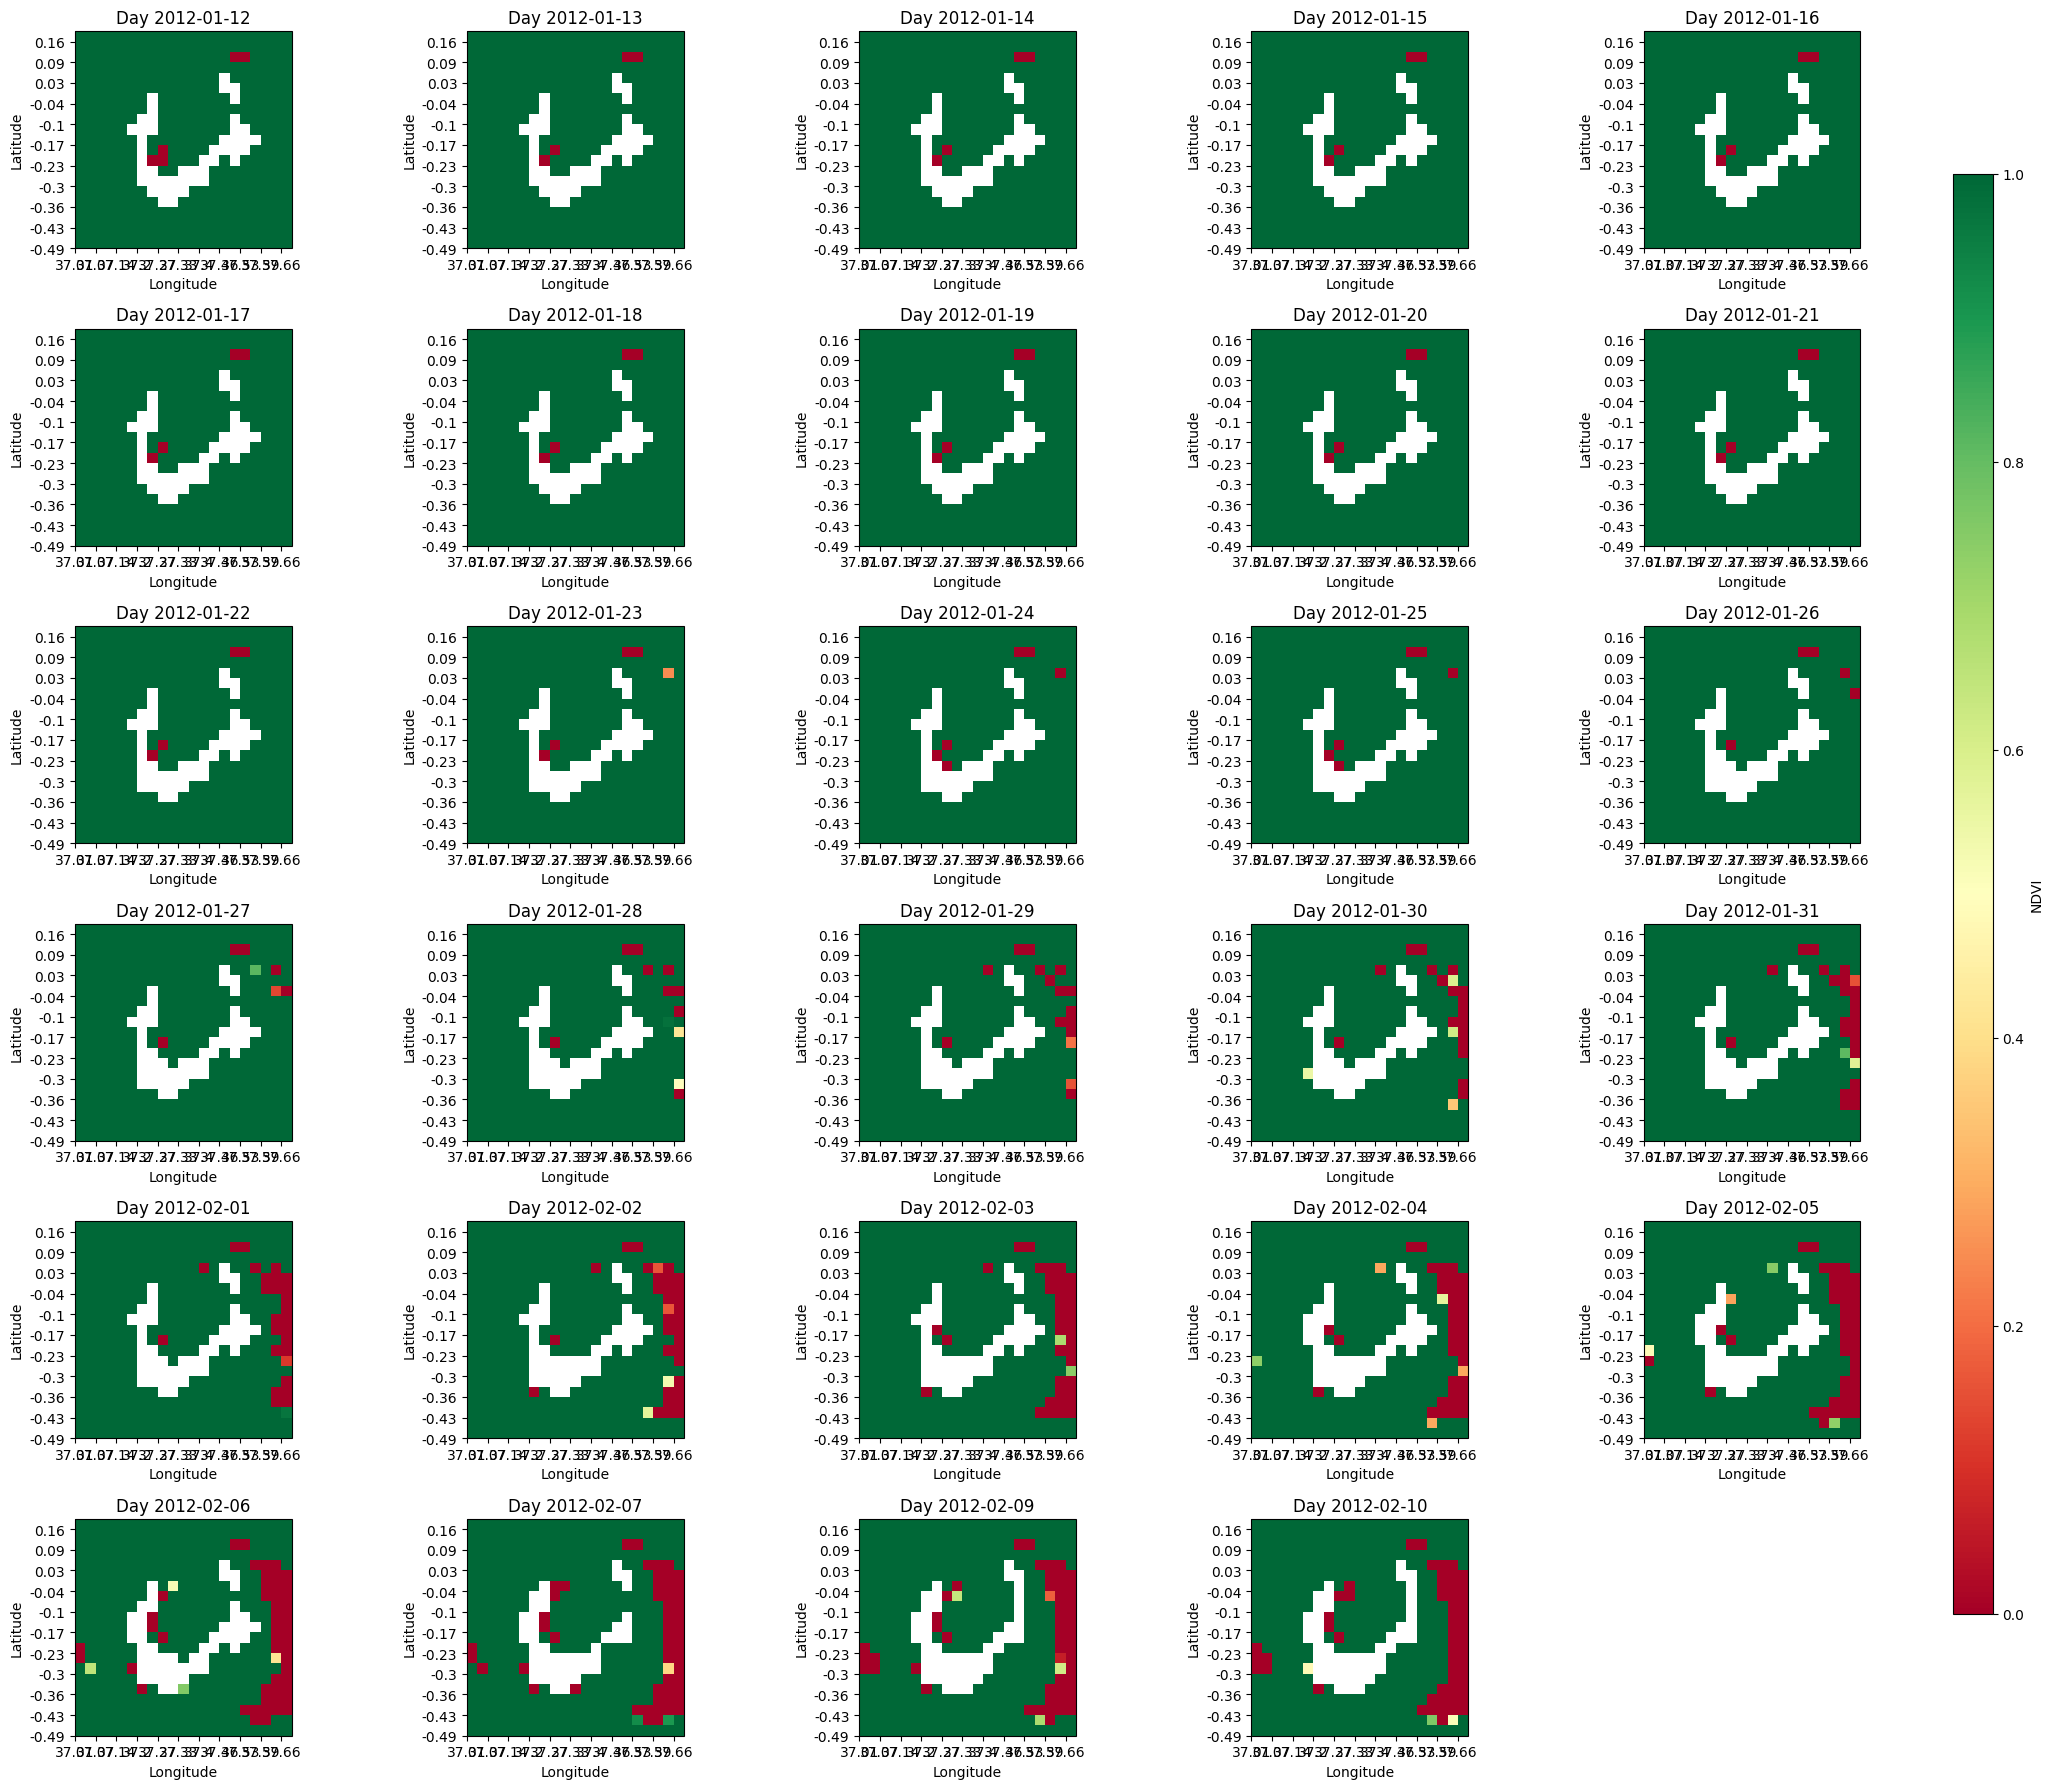

In [49]:
from analysis.visualizations.viz_series import plot_ndvi_days
import matplotlib.pyplot as plt
lat = 0.1521
lon = 37.3084

extra_area = 1.25

sub_ds = vci.where(sub_area<1).sel(time=slice(time_min, time_max))
    #.sel(lat=slice(lat-extra_area, lat+extra_area))\
    # .sel(lon=slice(lon-extra_area, lon+extra_area)))

plot_ndvi_days(sub_ds, time_min, 30, vmin=0, vmax=1, cmap="RdYlGn")

### Metrics

In [22]:
from vegetation import abs_diff, abs_mape

diff_1 = abs_diff(ds1.where(water_bodies==0))
diff_2 = abs_diff(ds2.where(water_bodies==0))
diff_3 = abs_diff(ds3.where(water_bodies==0))

mape_1 = abs_mape(ds1.where(water_bodies==0))
mape_2 = abs_mape(ds2.where(water_bodies==0))
mape_3 = abs_mape(ds3.where(water_bodies==0))

In [102]:
diff_5 = abs_diff(ds5.where(water_bodies==0))
diff_6 = abs_diff(ds6.ndvi_10.where(water_bodies==0))
diff_7 = abs_diff(ds7.where(water_bodies==0))

print("MAD:")
print(diff_5.mean().values)
print(diff_6.mean().values)
print(diff_7.mean().values)

print("MAD forest:")
print(diff_5.where(green_mask==1).mean().values)
print(diff_6.where(green_mask==1).mean().values)
print(diff_7.where(green_mask==1).mean().values)

MAD:
0.014971875
0.06392633
0.05352454
MAD forest:
0.02194717
0.11139397
0.08534074


In [23]:
print("MAD:")
print(diff_1.mean().values)
print(diff_2.mean().values)
print(diff_3.mean().values)

print("MAPE:")
print(mape_1.mean().values)
print(mape_2.mean().values)
print(mape_3.mean().values)

MAE:
0.0013884073
0.020086728
0.06807151
MAPE:
0.01218314
inf
0.7403726


In [25]:
print(diff_1.where(green_mask==1).mean().values)
print(diff_2.where(green_mask==1).mean().values)
print(diff_3.where(green_mask==1).mean().values)

0.0023730577
0.030637706
0.12279718


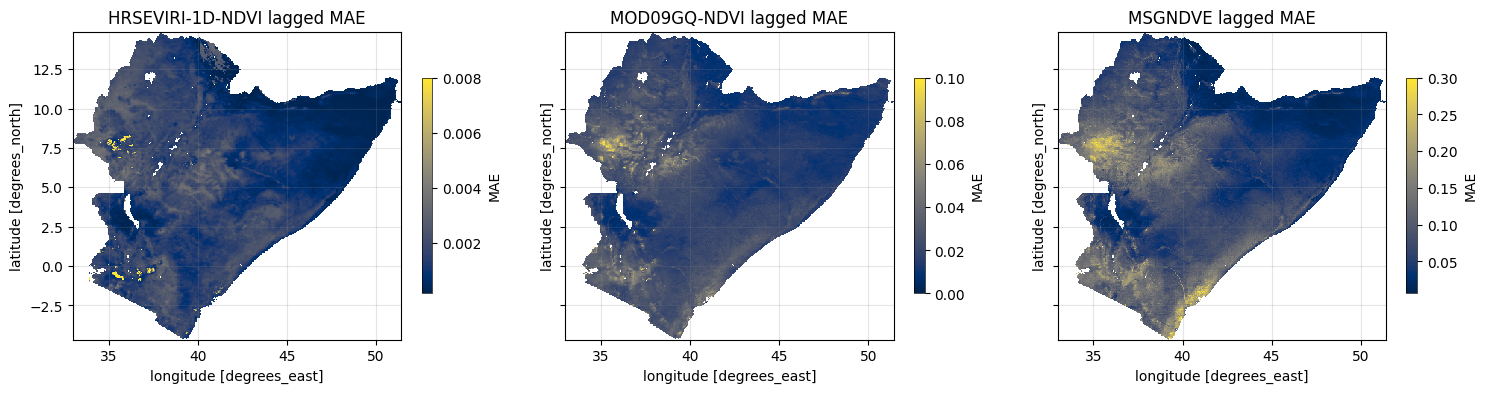

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming corr_a is a list of arrays or dataframes with data to plot
# corr_a[0] represents data for subplot 1, corr_a[1] for subplot 2, and corr_a[2] for subplot 3

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(18, 4))  # Creating subplots
titles = ["HRSEVIRI-1D-NDVI", "MOD09GQ-NDVI", "MSGNDVE"]
vmax = [0.008, 0.1, 0.3]

for i, corr_data in enumerate([diff_1, diff_2, diff_3]):
    plot = corr_data.mean(["time"]).plot(ax=axs[i],vmax=vmax[i], cmap="cividis", add_colorbar=False)
    axs[i].set_title(f"{titles[i]} lagged MAD", fontsize=12)
    axs[i].grid(True, color="grey", alpha=0.2)


    # Adding colorbar with a title
    cbar = fig.colorbar(plot, ax=axs[i], shrink=0.7)
    cbar.set_label('MAD')
    cbar.set_alpha(1)  # Set transparency
    cbar.outline.set_linewidth(0.5)  # Set colorbar outline linewidth
    cbar.outline.set_edgecolor('black')  # Set colorbar outline color

plt.show()